In [270]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.ticker as ticker
import numpy as np
import datetime

import os
path = os.getcwd()

In [271]:
# imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn import set_config
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
import seaborn as sns

In [272]:
df= pd.read_csv("../DF/df_for_regression.csv")
df.head()

,Unnamed: 0,Store ID,Item ID,Store Category,Store Segment,Store Region,City,Store Address,Item First Supplying Date,Item Last Supplying Date,...,Region Type,Cluster,Item_trailing_3_m_supply_date,Item Price,Count Ratings,Declared Supply,Meals Saved,Total Supply,Avg Rating Overall,Pickup Length
0,0,35,34,Indie - Outbound,Bakery,Vaud,Salavaux,Route de Vallamand 5,2019-06-06 00:00:00,2022-03-01,...,urban,3,2021-12-01,6.9,1.13,3.14,3.05,3.29,3.45,20.0
1,1,57,73,Indie - Outbound,Bakery,Freiburg,SÃ¢les,Route de la Rosaire 2,2019-06-08 00:00:00,2022-03-01,...,urban,0,2021-12-01,6.9,0.76,1.94,2.09,2.26,2.59,30.0
2,2,57,337152,Indie - Outbound,Bakery,Freiburg,SÃ¢les,Route de la Rosaire 2,2020-12-29 00:00:00,2020-12-29,...,urban,0,2020-09-30,6.9,0.00,1.00,1.00,1.00,0.00,30.0
3,3,58,74,Indie - Outbound,Bakery,Freiburg,Ursy,Route de Vauderens 6,2019-06-26 00:00:00,2022-02-26,...,urban,0,2021-11-28,4.9,0.59,0.00,1.30,1.34,2.73,30.0
4,4,58,337173,Indie - Outbound,Bakery,Freiburg,Ursy,Route de Vauderens 6,2020-12-28 00:00:00,2020-12-29,...,urban,0,2020-09-30,4.9,0.00,1.00,0.67,0.67,0.00,30.0


In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10151 entries, 0 to 10150
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     10151 non-null  int64  
 1   Store ID                       10151 non-null  int64  
 2   Item ID                        10151 non-null  int64  
 3   Store Category                 10151 non-null  object 
 4   Store Segment                  10151 non-null  object 
 5   Store Region                   10151 non-null  object 
 6   City                           10151 non-null  object 
 7   Store Address                  10151 non-null  object 
 8   Item First Supplying Date      10151 non-null  object 
 9   Item Last Supplying Date       10151 non-null  object 
 10  Supply Length                  10151 non-null  int64  
 11  Region Language                10151 non-null  object 
 12  Region Type                    10151 non-null 

## Data Preprocessing

In [274]:
# Check for duplicates
df.duplicated().sum()

0

In [275]:
# Check for nan:
df.isnull().sum().sort_values(ascending=False)

Unnamed: 0                       0
Store ID                         0
Avg Rating Overall               0
Total Supply                     0
Meals Saved                      0
Declared Supply                  0
Count Ratings                    0
Item Price                       0
Item_trailing_3_m_supply_date    0
Cluster                          0
Region Type                      0
Region Language                  0
Supply Length                    0
Item Last Supplying Date         0
Item First Supplying Date        0
Store Address                    0
City                             0
Store Region                     0
Store Segment                    0
Store Category                   0
Item ID                          0
Pickup Length                    0
dtype: int64

In [276]:
# Check for date columns to remove:
df[["Item First Supplying Date",'Item Last Supplying Date']].head()

,Item First Supplying Date,Item Last Supplying Date
0,2019-06-06 00:00:00,2022-03-01
1,2019-06-08 00:00:00,2022-03-01
2,2020-12-29 00:00:00,2020-12-29
3,2019-06-26 00:00:00,2022-02-26
4,2020-12-28 00:00:00,2020-12-29


### Add column to cluster Pickup start time

# Add column to cluster Pickup start time:
conditions = [
    (df['Pickup Time Start Time of Day'] <= "1900-01-01 11:59:00"),
    (df['Pickup Time Start Time of Day'] >= "1900-01-01 12:00:00") & (df['Pickup Time Start Time of Day'] < "1900-01-01 17:00:00"),
    (df['Pickup Time Start Time of Day'] >= "1900-01-01 17:00:00") & (df['Pickup Time Start Time of Day'] < "1900-01-01 21:00:00"),
    (df['Pickup Time Start Time of Day'] >= "1900-01-01 21:00:00")
    ]

values = ['morning', 'afternoon', 'early evening', 'late evening']

df['Pickup_time_of_day'] = np.select(conditions, values)

###  Convert Pickup Length

In [277]:
# Fuction to convert:
def pickup_conv(x):
    x=str(x)
    x=x[len(x)-8:len(x)]
    h,m,s = x.split(':')
    x=int((datetime.timedelta(hours=int(h),minutes=int(m),seconds=int(s)).total_seconds())/60)
    return x

In [278]:
#Converting the whole column
#df['Pickup Length']=df['Pickup Length'].map(pickup_conv)

In [279]:
#encoding = {"morning": 0, "afternoon": 1, "early evening": 2, "late evening": 3}
#df["encoded pickup time"] = df["Pickup_time_of_day"].map(encoding)

### Define Features

<AxesSubplot:>

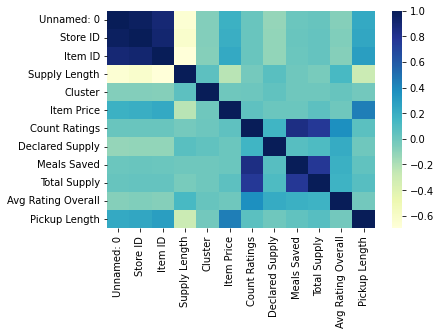

In [280]:
# Heatmap
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

In [281]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head()

,feature_1,feature_2,correlation
12,Store ID,Unnamed: 0,0.969253
1,Unnamed: 0,Store ID,0.969253
14,Store ID,Item ID,0.914539
25,Item ID,Store ID,0.914539
24,Item ID,Unnamed: 0,0.897341


### Define X and y

In [308]:
# Remove columns: define X and y
X = df.drop(columns=['Pickup Length','Unnamed: 0','Store ID','Item ID','City','Store Address', "Count Ratings", "Item_trailing_3_m_supply_date", "Item Last Supplying Date", "Item First Supplying Date", "Supply Length", "Declared Supply", "Meals Saved", "Avg Rating Overall"])
y = df["Pickup Length"]


In [309]:
X.head()

,Store Category,Store Segment,Store Region,Region Language,Region Type,Cluster,Item Price,Total Supply
0,Indie - Outbound,Bakery,Vaud,french,urban,3,6.9,3.29
1,Indie - Outbound,Bakery,Freiburg,french,urban,0,6.9,2.26
2,Indie - Outbound,Bakery,Freiburg,french,urban,0,6.9,1.00
3,Indie - Outbound,Bakery,Freiburg,french,urban,0,4.9,1.34
4,Indie - Outbound,Bakery,Freiburg,french,urban,0,4.9,0.67


In [310]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10151 entries, 0 to 10150
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Store Category   10151 non-null  object 
 1   Store Segment    10151 non-null  object 
 2   Store Region     10151 non-null  object 
 3   Region Language  10151 non-null  object 
 4   Region Type      10151 non-null  object 
 5   Cluster          10151 non-null  int64  
 6   Item Price       10151 non-null  float64
 7   Total Supply     10151 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 634.6+ KB


In [311]:
X.describe()

,Cluster,Item Price,Total Supply
count,10151.000000,10151.000000,10151.000000
mean,1.539454,8.008137,3.003183
std,1.076848,5.950009,15.513272
min,0.000000,0.010000,0.010000
25%,1.000000,5.900000,1.000000
50%,1.000000,5.900000,1.760000
75%,3.000000,7.900000,2.950000
max,3.000000,94.900000,800.000000


# Model 1: y=Price

In [312]:
# Split into Train/Test -> to do on all dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =42)

In [313]:
num_transformer = make_pipeline(RobustScaler())    #### Removed Simple Imputer
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
preprocess = make_column_transformer((num_transformer, ["Total Supply", 'Item Price', "Cluster"]),
                                     (cat_transformer,['Store Category', 'Store Segment', 'Store Region', 'Region Language', 'Region Type']))


In [314]:
# visualizing pipelines in HTML
#set_config(display='diagram')
#preprocess

In [315]:
#preprocess.fit(X_train)
X_train_transformed = preprocess.fit_transform(X_train)

In [316]:
display(pd.DataFrame(X_train_transformed.todense()).head(3))

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,-0.392857,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,-0.413265,-0.5,-0.5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.112245,0.0,-0.5,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [317]:
X_test

,Store Category,Store Segment,Store Region,Region Language,Region Type,Cluster,Item Price,Total Supply
621,Key Account,Cafeteria,Bern,german,urban,0,4.9,0.48
4404,Key Account,Supermarket Small,St. Gallen,german,urban,1,5.9,0.99
6795,Key Account,Supermarket Small,Aargau,german,rural,2,5.9,1.00
4607,Key Account,Supermarket Small,Aargau,german,rural,2,4.9,0.56
8165,Indie - Inbound,Traditional Restaurant,Uri,german,rural,1,7.9,0.62
...,...,...,...,...,...,...,...,...
7116,Key Account,Fast Food / Take away restaurant,Basel-Stadt,german,urban,0,22.9,1.67
2682,Indie - Outbound,Traditional Restaurant,Aargau,german,rural,2,6.9,2.81
4568,Key Account,Supermarket Small,Solothurn,german,rural,1,4.9,0.63
3597,Indie - Inbound,Buffet,Luzern,german,urban,0,7.9,2.28


In [321]:
# Add Estimator
#pipe = make_pipeline(preprocess, Ridge())
# lasso = Lasso(alpha=0.2).fit(X, y)
pipe1 = make_pipeline(preprocess, LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False))

In [319]:
pipe2 = make_pipeline(preprocess, ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.8,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False))

In [327]:
# Instanciate model
model2 = ElasticNet()

# Hyperparameter Grid
grid = {'alpha': [0.01, 0.1, 1], 
        'l1_ratio': [0.2, 0.5, 0.8]}

# Instanciate Grid Search
search2 = GridSearchCV(model2, grid, 
                           scoring = 'r2',
                           cv = 5,
                           n_jobs=-1 # paralellize computation
                          ) 

# Fit data to Grid Search
search2.fit(X_train_transformed, y_train)
search2.best_estimator_

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.8,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [328]:
model1 = LinearRegression()
parameters = {"fit_intercept": [True, False],
             }
search1 = GridSearchCV(estimator=model1, param_grid = parameters, cv = 5, n_jobs=-1)
search1.fit(X_train_transformed,y_train)
search1.best_estimator_

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [322]:
# Cross validate pipeline
cross_val_score(pipe1, pd.DataFrame(X_train), y_train, cv=3, scoring='r2').mean()

0.4207002668636403

In [323]:
# Cross validate pipeline
cross_val_score(pipe2, X_train, y_train, cv=3, scoring='r2').mean()

0.4223343072463585

In [324]:
# Train pipeline
pipe1.fit(X_train, y_train)

# Make predictions
pipe1.predict(X_test)

# Score model
pipe1.score(X_test, y_test)

0.4643026026874132

In [325]:
# Train pipeline
pipe2.fit(X_train, y_train)

# Make predictions
pipe2.predict(X_test)

# Score model
pipe2.score(X_test, y_test)

0.46451434733382935

<AxesSubplot:>

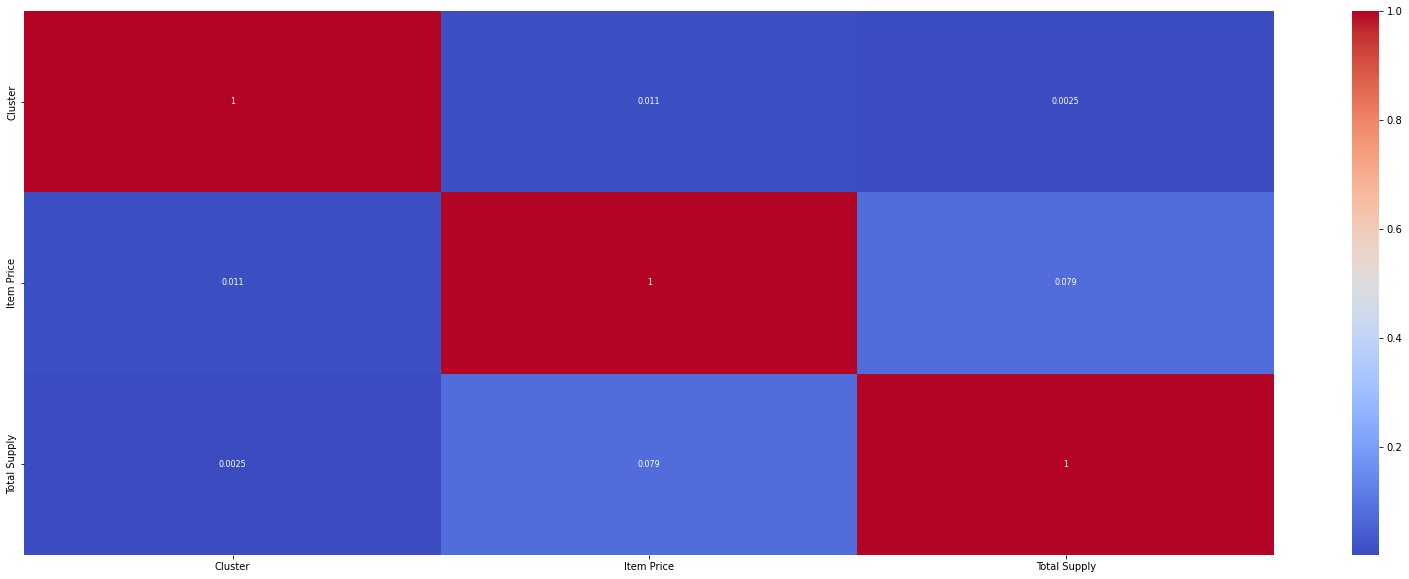

In [326]:
# Checking correlation between independent variables (features):
# Need to encode categorical variables
plt.figure(figsize=(28,10))
sns.heatmap(X_train.corr(), cmap='coolwarm', annot = True, annot_kws={"size": 8})